<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/naive_bayes_classifier_for_the_early_detection_of_cardiovascular_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

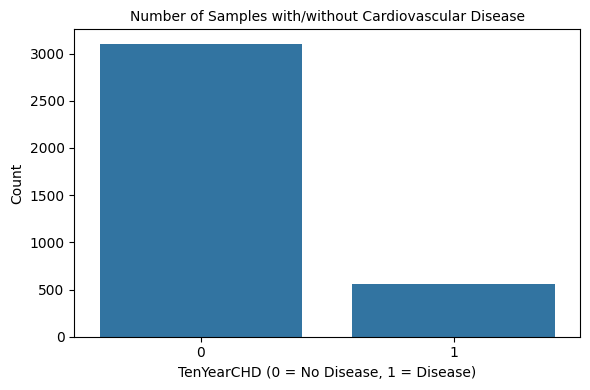


⚖️ Class Distribution Before Oversampling:
TenYearCHD
0    3101
1     557
Name: count, dtype: int64

Resampled 3570 samples for gender subset
TenYearCHD
0    1785
1    1785
Name: count, dtype: int64

Resampled 3570 samples for gender subset
TenYearCHD
0    1785
1    1785
Name: count, dtype: int64

🔍 Top 8 Features for Male: ['age', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'glucose']

Number of training samples for Male: 2856
Number of testing samples for Male: 714


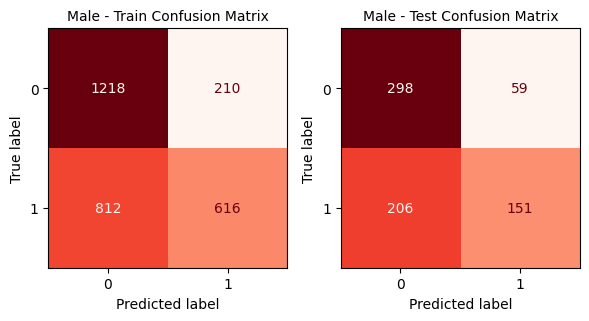


📈 Performance Metrics for Male:


,Accuracy,Precision,Recall,F1-Score
Train,0.642157,0.745763,0.431373,0.546584
Test,0.628852,0.719048,0.422969,0.532628



🔍 Top 8 Features for Female: ['age', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose']

Number of training samples for Female: 2856
Number of testing samples for Female: 714


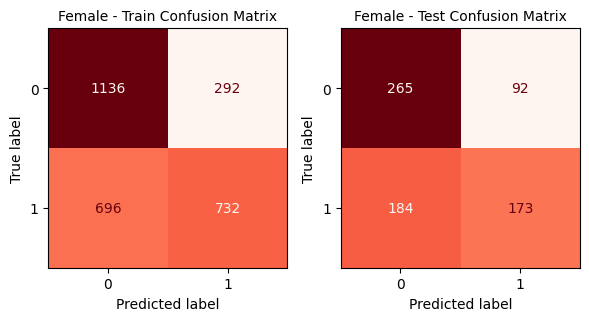


📈 Performance Metrics for Female:


,Accuracy,Precision,Recall,F1-Score
Train,0.654062,0.714844,0.512605,0.597064
Test,0.613445,0.652830,0.484594,0.556270



📋 Final Combined Performance Metrics:


,Accuracy,Precision,Recall,F1-Score
Male - Train,0.642157,0.745763,0.431373,0.546584
Male - Test,0.628852,0.719048,0.422969,0.532628
Female - Train,0.654062,0.714844,0.512605,0.597064
Female - Test,0.613445,0.652830,0.484594,0.556270


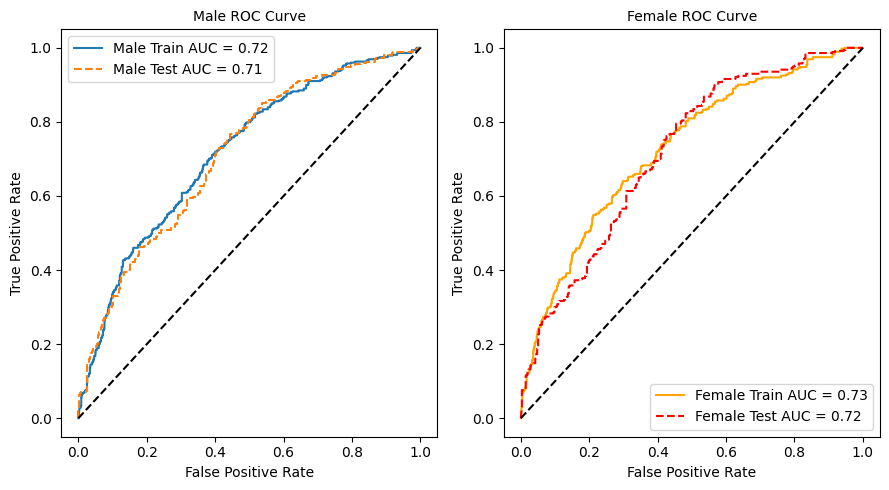

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Create output directory
output_dir = "output_figures"
os.makedirs(output_dir, exist_ok=True)

# Load dataset
df = pd.read_csv('framingham.csv')

# Drop missing values early
df.dropna(inplace=True)

# Plot original class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='TenYearCHD')
plt.title('Number of Samples with/without Cardiovascular Disease', fontsize=10)
plt.xlabel('TenYearCHD (0 = No Disease, 1 = Disease)', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'class_distribution.png'))
plt.show()

print("\n⚖️ Class Distribution Before Oversampling:")
print(df['TenYearCHD'].value_counts())

# Split by gender first (before balancing)
df_male = df[df['male'] == 1].drop(columns=['male'])
df_female = df[df['male'] == 0].drop(columns=['male'])

def resample_to_target(df_gender, target_samples=3570):
    # Separate features and labels
    X = df_gender.drop('TenYearCHD', axis=1)
    y = df_gender['TenYearCHD']

    # Total samples currently
    n_samples = len(df_gender)

    if n_samples > target_samples:
        # Undersample to target_samples total
        rus = RandomUnderSampler(sampling_strategy={0: target_samples//2, 1: target_samples//2}, random_state=23)
        X_res, y_res = rus.fit_resample(X, y)
    else:
        # Oversample to target_samples total
        ros = RandomOverSampler(sampling_strategy={0: target_samples//2, 1: target_samples//2}, random_state=23)
        X_res, y_res = ros.fit_resample(X, y)

    df_resampled = pd.concat([X_res, y_res], axis=1)
    print(f"\nResampled {len(df_resampled)} samples for gender subset")
    print(df_resampled['TenYearCHD'].value_counts())
    return df_resampled

df_male_balanced = resample_to_target(df_male, target_samples=3570)
df_female_balanced = resample_to_target(df_female, target_samples=3570)

def train_naive_bayes_model(data, label='TenYearCHD', gender='Male'):
    X = data.drop(label, axis=1)
    y = data[label]

    # Feature selection
    selector = SelectKBest(score_func=f_classif, k=7)
    X_selected = selector.fit_transform(X, y)
    top_features = X.columns[selector.get_support()]
    print(f"\n🔍 Top 8 Features for {gender}: {list(top_features)}")

    # Save top features
    pd.Series(top_features).to_csv(os.path.join(output_dir, f'top_features_{gender.lower()}.csv'), index=False)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=22, stratify=y
    )

    print(f"\nNumber of training samples for {gender}: {X_train.shape[0]}")
    print(f"Number of testing samples for {gender}: {X_test.shape[0]}")

    # Train model
    model = GaussianNB()
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Confusion matrix plots
    fig, axes = plt.subplots(1, 2, figsize=(6, 5))
    for ax, (dataset_type, y_true, y_pred) in zip(axes, [
        ('Train', y_train, y_train_pred),
        ('Test', y_test, y_test_pred)
    ]):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, colorbar=False, cmap='Reds')
        ax.set_title(f'{gender} - {dataset_type} Confusion Matrix', fontsize=10)
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{gender}_train_test_conf_matrix.png'))
    plt.show()

    # Metrics
    metrics = {
        'Accuracy': [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
        'Recall': [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
        'F1-Score': [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)]
    }
    df_metrics = pd.DataFrame(metrics, index=['Train', 'Test'])
    print(f"\n📈 Performance Metrics for {gender}:")
    display(df_metrics)

    # ROC Curves
    y_score_train = model.predict_proba(X_train)[:, 1]
    y_score_test = model.predict_proba(X_test)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)

    # Return ROC data for combined plotting
    return df_metrics, (fpr_train, tpr_train), (fpr_test, tpr_test)

def plot_combined_roc(male_roc_train, male_roc_test, female_roc_train, female_roc_test):
    fig, axes = plt.subplots(1, 2, figsize=(9, 5))

    # Male ROC subplot
    axes[0].plot(male_roc_train[0], male_roc_train[1], label=f'Male Train AUC = {auc(*male_roc_train):.2f}')
    axes[0].plot(male_roc_test[0], male_roc_test[1], label=f'Male Test AUC = {auc(*male_roc_test):.2f}', linestyle='--')
    axes[0].plot([0,1], [0,1], 'k--')
    axes[0].set_title('Male ROC Curve', fontsize=10)
    axes[0].set_xlabel('False Positive Rate', fontsize=10)
    axes[0].set_ylabel('True Positive Rate', fontsize=10)
    axes[0].tick_params(axis='x', labelsize=10)
    axes[0].tick_params(axis='y', labelsize=10)
    axes[0].legend(fontsize=10)

    # Female ROC subplot
    axes[1].plot(female_roc_train[0], female_roc_train[1], label=f'Female Train AUC = {auc(*female_roc_train):.2f}', color='orange')
    axes[1].plot(female_roc_test[0], female_roc_test[1], label=f'Female Test AUC = {auc(*female_roc_test):.2f}', color='red', linestyle='--')
    axes[1].plot([0,1], [0,1], 'k--')
    axes[1].set_title('Female ROC Curve', fontsize=10)
    axes[1].set_xlabel('False Positive Rate', fontsize=10)
    axes[1].set_ylabel('True Positive Rate', fontsize=10)
    axes[1].tick_params(axis='x', labelsize=10)
    axes[1].tick_params(axis='y', labelsize=10)
    axes[1].legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'combined_roc_curves.png'))
    plt.show()

# Train and evaluate with balanced data
metrics_male, male_roc_train, male_roc_test = train_naive_bayes_model(df_male_balanced, gender='Male')
metrics_female, female_roc_train, female_roc_test = train_naive_bayes_model(df_female_balanced, gender='Female')

# Combine metrics
final_metrics = pd.concat([
    metrics_male.rename(index=lambda x: f'Male - {x}'),
    metrics_female.rename(index=lambda x: f'Female - {x}')
])

print("\n📋 Final Combined Performance Metrics:")
display(final_metrics)

# Plot combined ROC curves
plot_combined_roc(male_roc_train, male_roc_test, female_roc_train, female_roc_test)


In [ ]:
df_male_balanced.shape

(3570, 15)

In [ ]:
df_female_balanced.shape

(3570, 15)